In [2]:
from jenkspy import JenksNaturalBreaks
import pandas as pd
import numpy as np
import time
import os
import pickle
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import PredefinedSplit
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import tensorflow as tf
import shap
from tensorflow.keras import layers
from skopt import BayesSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
import sqlite3

import modules.feature_selection as fs
import modules.helper_functions as hf
import modules.filter_rows as fr

# Implementing of the routing algorithm

In order to bring the application to production and test the approach on live-data it is important to implement several pre-conditions to be able to do so. First the necessary features have to be extracted from the available data. The important features for the machine learning model are:

### Load global objects

In [3]:
model = hf.loadPickle('./models/xgb_clf_final.pkl')
# features = hf.loadPickle('./models/xgb_clf_final_features.pkl')
parameters = hf.loadPickle('./data/parameters.pkl')
features = parameters['features']

In [4]:
pathDb = './data/PSP_Data.sqlite'
X_test = hf.readSqlTable(pathDb, "X_test")
y_test = hf.readSqlTable(pathDb, "y_test")

### Define pipeline

In [5]:
def generate_sample(timestamp, amount, card, country, secured, psp_list, parameters):
    
    example_timestamp = pd.Timestamp(timestamp)
    example_amount = amount
    example_card = card
    example_country = country
    example_3D_secured = secured

    example = pd.DataFrame({"tmsp": [example_timestamp, example_timestamp, example_timestamp, example_timestamp], 
                            "country": [example_country, example_country, example_country, example_country], 
                            "amount": [example_amount, example_amount, example_amount, example_amount], 
                            "card": [example_card, example_card, example_card, example_card],
                            "3D_secured": [example_3D_secured, example_3D_secured, example_3D_secured, example_3D_secured],
                            "PSP": psp_list
                           })
    
    example = hf.get_amountgroups(example, bins = parameters["jenks"])
    
    return example

In [6]:
def get_failFeatures(data, path_db = './data/PSP_Data.sqlite', table = 'TB003_DATA_PREPARED', delete = False):
    
    out = data.copy()
    cutoff_time = str(data.tmsp.iloc[0] + pd.Timedelta(minutes = -1))
    conn = sqlite3.connect(path_db)
    duplicates = pd.read_sql(
    f"""
        SELECT * FROM {table}
        WHERE 
            (country = '{out.country[0]}') AND
            (amount = {out.amount[0]}) AND
            (tmsp >= '{cutoff_time}') AND
            (tmsp <= '{str(out.tmsp.iloc[0])}')
    """, conn
    )
    
    if len(duplicates) > 0:
        if delete:
            out['failPrevious'] = 1
            for psp in list(out.PSP):
                out['failed_' + psp] = duplicates['failed_' + psp][0]
            out['failed_' + duplicates.PSP[0]] = 1
            cur = conn.cursor()
            cur.execute(f"DELETE FROM {table} WHERE {table}.[index] IN ({', '.join([str(x) for x in duplicates['index']])})")
            conn.commit()
            print("=== Redundant entries removed from database ===")
        else:
            out["failPrevious"] = duplicates["failPrevious"][0]
            for psp in list(out.PSP):
                out['failed_' + psp] = duplicates['failed_' + psp][0]
            out['failed_' + duplicates.PSP[0]] = 1
    else:
        out['failPrevious'] = 0
        for psp in list(out.PSP):
            out['failed_' + psp] = 0
    
    conn.close()
    
    return out

In [7]:
def get_time_features(data):
    out = data.copy()
    hours = out["tmsp"].dt.hour
    minutes = out["tmsp"].dt.minute
    day = out["tmsp"].dt.day
    out["minuteOfDay"] = hours*60 + minutes
    out["dayOfMonth"] = day
    
    return out

In [8]:
def get_combinatoric_SR(data, pathDb, table, parameters):
    out = data.copy()
    rowNum = parameters["train_split_iloc"]
    conn = sqlite3.connect(pathDb)
    psp_sr = pd.read_sql(f"""
        SELECT PSP, AVG(SUCCESS) AS PSP_SR FROM {table}
        WHERE ROWID <= {rowNum}
        GROUP BY PSP
    """, conn)
    out = out.merge(psp_sr, how="left", on = ["PSP"])
    psp_card_sr = pd.read_sql(f"""
        SELECT PSP, card, AVG(SUCCESS) AS PSP_card_SR FROM {table}
        WHERE ROWID <= {rowNum}
        GROUP BY PSP, card
    """, conn)
    out = out.merge(psp_card_sr, how="left", on = ["PSP", "card"])
    psp_card_sec_sr = pd.read_sql(f"""
        SELECT PSP, card, TB003_DATA_PREPARED.[3D_secured], AVG(SUCCESS) AS PSP_card_3D_secured_SR FROM TB003_DATA_PREPARED
        WHERE ROWID <= {rowNum}
        GROUP BY PSP, card, TB003_DATA_PREPARED.[3D_secured]
    """, conn)
    out = out.merge(psp_card_sec_sr, how="left", on = ["PSP", "card", "3D_secured"])
    psp_card_sec_amountgroup_sr = pd.read_sql(f"""
        SELECT PSP, card, TB003_DATA_PREPARED.[3D_secured], 
            amountgroup_word, 
            AVG(SUCCESS) AS PSP_card_3D_secured_amountgroup_word_SR FROM TB003_DATA_PREPARED
        WHERE ROWID <= {rowNum}
        GROUP BY PSP, card, TB003_DATA_PREPARED.[3D_secured], amountgroup_word
    """, conn)
    out = out.merge(psp_card_sec_amountgroup_sr, how="left", on = ["PSP", "card", "3D_secured", "amountgroup_word"])
    conn.close()
    
    return out

In [9]:
def get_combinatoric_event_window_SR(data, pathDb = './data/PSP_Data.sqlite', table = "TB003_DATA_PREPARED", event_window = 10):
    out = data.copy()
    tmsp = str(out.tmsp.iloc[0])
    conn = sqlite3.connect(pathDb)
    psps = out["PSP"]
    card = out.card.iloc[0]
    secured = out["3D_secured"].iloc[0]
    amountgroup = out["amountgroup_word"].iloc[0]
    out["PSP_e" + str(event_window) + "_SR"] = 0
    out["PSP_card_e" + str(event_window) + "_SR"] = 0
    out["PSP_card_3D_secured_e" + str(event_window) + "_SR"] = 0
    for psp in psps:
        psp_sr = pd.read_sql(f"""
            SELECT AVG(success) FROM
            (SELECT tmsp, PSP, success FROM {table}
            WHERE tmsp < '{tmsp}' AND PSP = '{psp}'
            ORDER BY tmsp DESC
            LIMIT {event_window})
        """, conn)
        out["PSP_e" + str(event_window) + "_SR"] = np.where(out["PSP"] == psp, psp_sr.iloc[0, 0], out["PSP_e" + str(event_window) + "_SR"])
        out["PSP_e" + str(event_window) + "_SR"] = out["PSP_e" + str(event_window) + "_SR"].fillna(out["PSP_SR"])
        psp_card_sr = pd.read_sql(f"""
            SELECT AVG(success) FROM
            (SELECT tmsp, card, PSP, success FROM {table}
            WHERE tmsp < '{tmsp}' AND PSP = '{psp}' AND card = '{card}'
            ORDER BY tmsp DESC
            LIMIT {event_window})
        """, conn)
        out["PSP_card_e" + str(event_window) + "_SR"] = np.where(out["PSP"] == psp, 
                                                                 psp_card_sr.iloc[0, 0], 
                                                                 out["PSP_card_e" + str(event_window) + "_SR"])
        out["PSP_card_e" + str(event_window) + "_SR"] = out["PSP_card_e" + str(event_window) + "_SR"].fillna(out["PSP_card_SR"])
        psp_card_secured_sr = pd.read_sql(f"""
            SELECT AVG(success) FROM
            (SELECT tmsp, card, PSP, {table}.[3D_secured], success FROM {table}
            WHERE tmsp < '{tmsp}' AND PSP = '{psp}' AND card = '{card}' AND {table}.[3D_secured] = {secured}
            ORDER BY tmsp DESC
            LIMIT {event_window})
        """, conn)
        out["PSP_card_3D_secured_e" + str(event_window) + "_SR"] = np.where(out["PSP"] == psp, 
                                                                            psp_card_secured_sr.iloc[0, 0], 
                                                                            out["PSP_card_3D_secured_e" + str(event_window) + "_SR"])
        out["PSP_card_3D_secured_e" + str(event_window) + "_SR"] = out["PSP_card_3D_secured_e" + str(event_window) + "_SR"].fillna(out["PSP_card_3D_secured_SR"])
    conn.close()
    
    return out

In [10]:
def get_combinatoric_time_window_SR(data, pathDb = './data/PSP_Data.sqlite', table = "TB003_DATA_PREPARED", time_window = 6):
    out = data.copy()
    timestamp = pd.Timestamp(out.tmsp.iloc[0])
    cutoff_time = str(timestamp + pd.Timedelta(hours = -time_window))
    conn = sqlite3.connect(pathDb)
    out["PSP_t" + str(time_window) + "h_SR"] = 0
    for psp in out.PSP:
        outcome = pd.read_sql(f"""
            SELECT AVG(success) AS PSP_t{time_window}h_SR FROM {table}
            WHERE PSP = '{psp}' AND tmsp >= '{cutoff_time}' AND tmsp < '{str(timestamp)}'
        """, conn)
        out["PSP_t" + str(time_window) + "h_SR"] = np.where(out["PSP"] == psp, outcome.iloc[0, 0], out["PSP_t" + str(time_window) + "h_SR"])
    conn.close()
    
    return out

In [11]:
def get_one_hot_features(data, columns = ["PSP", 'card']):
    out = data.copy()
    for column in columns:
        try:
            out = pd.get_dummies(out, columns = [column])
        except:
            print("column " + column + " already exists")
    
    return out

In [12]:
def replace_missings(data, features):
    out = data.copy()
    diff = list(set(features) - set(out.columns))
    
    if len(diff) > 0:
        for col in diff:
            out[col] = 0
    
    return out

In [13]:
def scale_features(data, parameters):
    out = data.copy()
    scaleCols = parameters["scale_columns"]
    out[scaleCols] = parameters["scaler"].transform(out[scaleCols])
    
    return out

In [14]:
def orchestrate(
    timestamp, 
    amount, 
    card, 
    country, 
    secured, 
    features, 
    psp_list,
    parameters,
    pathDb = './data/PSP_Data.sqlite',
    table = 'TB003_DATA_PREPARED'):
    
    example = generate_sample(timestamp, amount, card, country, secured, psp_list, parameters)
    example = get_failFeatures(example, table = table)
    example = get_time_features(example)
    example = get_combinatoric_SR(example, pathDb, table, parameters)
    example = get_combinatoric_event_window_SR(example, event_window = 10)
    example = get_combinatoric_event_window_SR(example, event_window = 100)
    example = get_combinatoric_event_window_SR(example, event_window = 200)
    example = get_combinatoric_time_window_SR(example, time_window = 6)
    example = get_combinatoric_time_window_SR(example, time_window = 12)
    example = get_one_hot_features(example)
    example = replace_missings(example, features)
    example = scale_features(example, parameters)
    
    return example

In [25]:
def generate_prediction(row_id, features, show_explanations = True, pathDb = './data/PSP_Data.sqlite', verbose = 0):
    start_time = time.time()
    
    conn = sqlite3.connect(pathDb)
    data = pd.read_sql(f"SELECT * FROM TB003_DATA_PREPARED WHERE TB003_DATA_PREPARED.[index] = {row_id}", conn)
    conn.close()
    
    fee_dict = {"Goldcard": [10, 5], "Simplecard": [1, 0.5], "Moneycard": [5, 2], "UK_Card": [3, 1]}
    example = orchestrate(
        timestamp = str(pd.Timestamp(data['tmsp'].iloc[0])),
        amount = data['amount'].iloc[0],
        card = data['card'].iloc[0],
        country = data['country'].iloc[0],
        secured = data['3D_secured'].iloc[0],
        features = features,
        psp_list = list(fee_dict.keys()),
        parameters = parameters
    ).fillna(0)
    
    if verbose > 0:
        print("=== Time to execute: " + str(time.time() - start_time) + " ===")
    
    if show_explanations:
        explainer = shap.TreeExplainer(model,  model_output="probability", feature_perturbation='interventional', data=example[features])
        shap_values = explainer.shap_values(example[features])
        
        print("Shap expected value: " + str(explainer.expected_value))
        print("Barplot for PSP: " + list(fee_dict.keys())[0] + " (" + str(explainer.expected_value + shap_values[0, :].sum()) + ")")
        shap.bar_plot(shap_values[0, :], feature_names=example[features].columns, max_display=15)
        print("Barplot for PSP: " + list(fee_dict.keys())[1] + " (" + str(explainer.expected_value + shap_values[1, :].sum()) + ")")
        shap.bar_plot(shap_values[1, :], feature_names=example[features].columns, max_display=15)
        print("Barplot for PSP: " + list(fee_dict.keys())[2] + " (" + str(explainer.expected_value + shap_values[2, :].sum()) + ")")
        shap.bar_plot(shap_values[2, :], feature_names=example[features].columns, max_display=15)
        print("Barplot for PSP: " + list(fee_dict.keys())[3] + " (" + str(explainer.expected_value + shap_values[3, :].sum()) + ")")
        shap.bar_plot(shap_values[3, :], feature_names=example[features].columns, max_display=15)
    
    out = pd.DataFrame({"PSP": fee_dict.keys(), 
                        "probability": model.predict_proba(example[features])[:, 1], 
                        "fee_pos": [x[0] for x in fee_dict.values()],
                        "fee_neg": [x[1] for x in fee_dict.values()]
                       })
    probability_table = out
    out = out[out["probability"] >= 0.29]
    out = out.sort_values(by = ["fee_pos"])
    
    if verbose > 0:
        if len(out) == 0:
            print("Selection defaults to cheapest PSP: Simplecard")
            print("Probability table:")
            print(probability_table)
        else:
            print("=== Recommendation table:")
            print(out)
            print("=== Complete probability table:")
            print(probability_table)
    
    probability_table = probability_table[probability_table.probability >= 0.29].sort_values(by = ["fee_pos"])
    
    return probability_table

### Generate example live-prediction for observation with row id 23238

=== Time to execute: 0.8567819595336914 ===
Shap expected value: 0.5607914693410037
Barplot for PSP: Goldcard (0.6253083034234562)


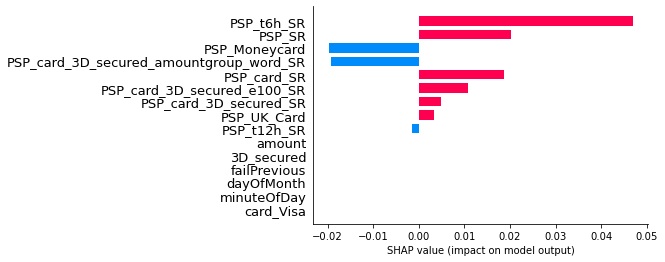

Barplot for PSP: Simplecard (0.37893817397408674)


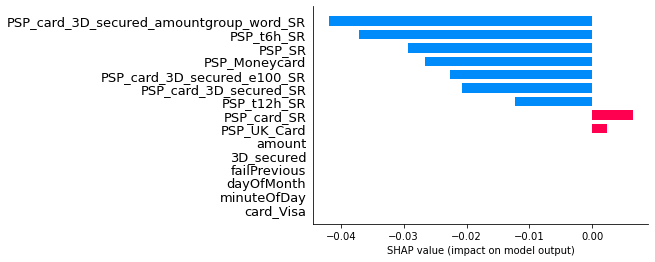

Barplot for PSP: Moneycard (0.6402608778708403)


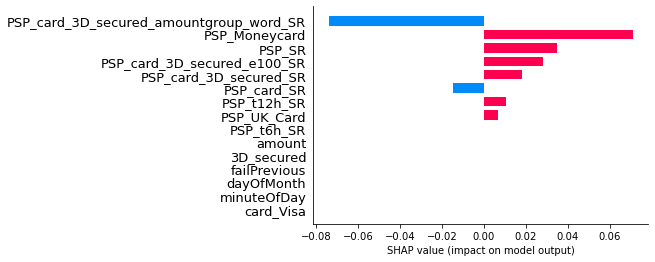

Barplot for PSP: UK_Card (0.5986585220956313)


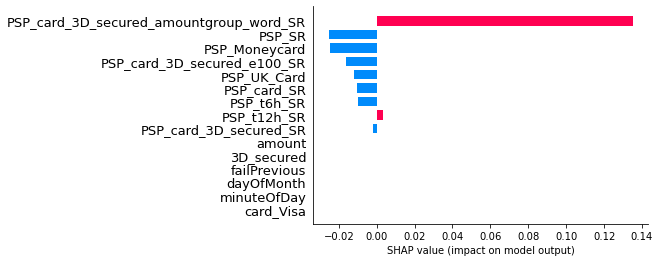

=== Recommendation table:
          PSP  probability  fee_pos  fee_neg
1  Simplecard     0.378938        1      0.5
3     UK_Card     0.598659        3      1.0
2   Moneycard     0.640261        5      2.0
0    Goldcard     0.625308       10      5.0
=== Complete probability table:
          PSP  probability  fee_pos  fee_neg
0    Goldcard     0.625308       10      5.0
1  Simplecard     0.378938        1      0.5
2   Moneycard     0.640261        5      2.0
3     UK_Card     0.598659        3      1.0


,PSP,probability,fee_pos,fee_neg
1,Simplecard,0.378938,1,0.5
3,UK_Card,0.598659,3,1.0
2,Moneycard,0.640261,5,2.0
0,Goldcard,0.625308,10,5.0


In [26]:
generate_prediction(23238, features, verbose = 1)

**The example was a successful transaction for PSP UK_Card.**

### Generate example live-prediction for observation with row id 27321

=== Time to execute: 0.9831907749176025 ===
Shap expected value: 0.43103665558290494
Barplot for PSP: Goldcard (0.5206629619824207)


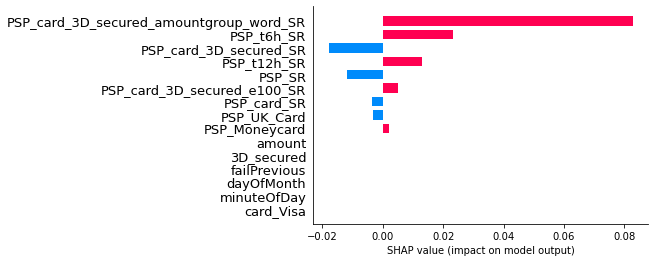

Barplot for PSP: Simplecard (0.29549748712209745)


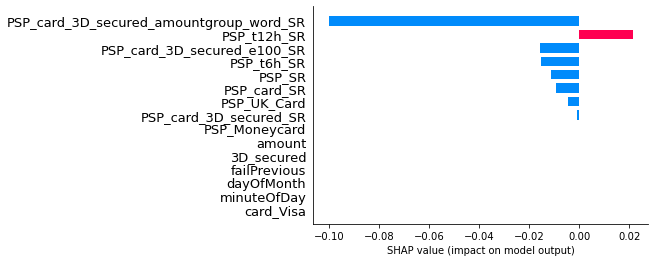

Barplot for PSP: Moneycard (0.41006203688266313)


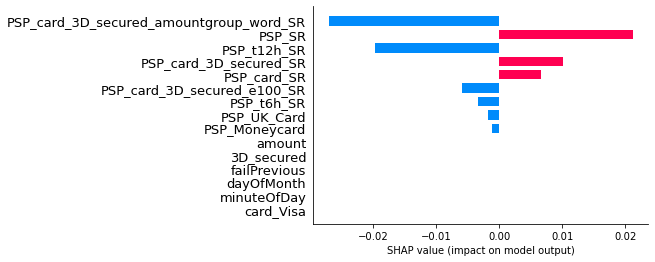

Barplot for PSP: UK_Card (0.49792413634443855)


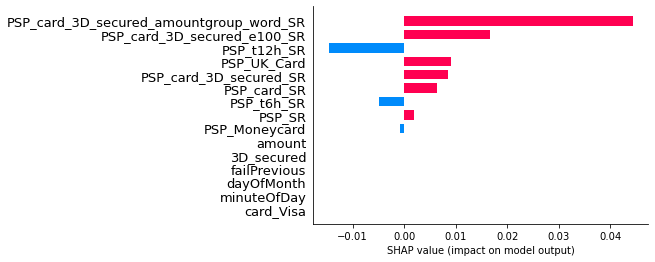

=== Recommendation table:
          PSP  probability  fee_pos  fee_neg
1  Simplecard     0.295497        1      0.5
3     UK_Card     0.497924        3      1.0
2   Moneycard     0.410062        5      2.0
0    Goldcard     0.520663       10      5.0
=== Complete probability table:
          PSP  probability  fee_pos  fee_neg
0    Goldcard     0.520663       10      5.0
1  Simplecard     0.295497        1      0.5
2   Moneycard     0.410062        5      2.0
3     UK_Card     0.497924        3      1.0


,PSP,probability,fee_pos,fee_neg
1,Simplecard,0.295497,1,0.5
3,UK_Card,0.497924,3,1.0
2,Moneycard,0.410062,5,2.0
0,Goldcard,0.520663,10,5.0


In [27]:
generate_prediction(27321, features, verbose = 1)

**The example was an unsuccessful transaction for PSP Moneycard.**